# Toxic Comment Classification

This notebook is based off Lesson 3 of fast.ai - creating a text classification model using the [ULMFiT](https://arxiv.org/pdf/1801.06146.pdf) method. ULMFiT uses a three stage training protocol to create a text classification model.
 1. First a language model is trained on a large text corpus
 2. The language model is fine tuned on the classification corpus to create a fine tuned language model
 3. The fine tuned language model is used as the basis of the final classification model
 
What's the logic behind this approach? Lets break down each stage.

### The Language Model

A fundamental assumption in ULMFiT is that classifying text samples requires an understanding of the language the texts are written in. This is in contrast to more traditional classification techniques like bag of word and text frequency approaches, which focus more on word frequency. The foundation of a ULMFiT model is a language model trained to understand the language underlying the classification task. Language understanding is measured using accuracy - the ability for the model to correctly predict the next word in an input string. There are a lot of ways to measure understanding of a language. Accuracy may not be the perfect metric, but for the purpose of evaluating the model's language ability it seems to function well.

To this end, the language model can be trained on text data outside the classification data. If we trust the assumption that language understanding is key to text classification, we want to train the language model on the largest, most representative corpus available. The base language model used in this notebook is an english language model trained on the [WikiText-103](https://www.salesforce.com/products/einstein/ai-research/the-wikitext-dependency-language-modeling-dataset/) dataset.

### Fine Tuned Language Model

Now that we have a specialized language model that understands the english language in general, we want to specialize it to the specific text corpus we want to work with. In this case we're looking at the [Quora Insincere Questions Classification](https://www.kaggle.com/c/quora-insincere-questions-classification) dataset. We expect the dataset we're actually working with to contain learnable domain information that would not be present in the general WikiText-103 dataset. Maybe particular words or sentence structures are noticeable in the dataset. For example in the Quora dataset, every text input is a question. We might also want to update the vocabulary of the model to reflect word frequency distributions in the classification dataset. Fine tuning the language model to the classification corpus helps optimize the language model for task specific features of the classification dataset.

During fine tuning, we train the model using discriminative learning rates. Earlier layers in the model are trained at a lower learning rate than the later layers.

### Classification Model

Once we have a fine tuned language model, we can create the classification model. This involves adding a new linear layer to the language model that outputs predictions for the number of classes in the dataset. We train this model using both discriminative learning rate and gradual unfreezing. This means firstly that most of the training goes towards the new linear layer - we assume the language features extracted by the language model layers are well tuned. We also freeze most of the model at the start of training, and gradually unfreeze layers as training progresses.

### Data Preparation

The text data needs to be converted to a numerical form before being sent to the model. We accomplish this in two steps - tokenizing and numericalizing the text. Tokenization breaks up strings into word level tokens. fastai defaults to using [Spacy](https://spacy.io/api/tokenizer) to tokenize text. Tokenization breaks down compound words, for example tokenizing `don't` into `do 'nt`. Tokenizing also adds elements of sentence structure. Each sentence starts with a `xxbos` token. Capitalized letters are denoted with a token - `Here` becomes `xxmaj here`. This way, we can retain the information contained in the capitalization without having to  track multiple versions of a word.

When we tokenize, we also decide what the vocabulary of the model will be. It's not computationally feasible to train a model using every single word in the english language. We select a vocabulary of the 60000 most used words in the text corpus, and replace all other words with a `<unk>` token.

Once text has been tokenized, we can numericalize text by mapping each token to a numerical id. This converts text strings to a vector of numbers that can be consumed by a neural network.


### Model Architecture

The models we use for all stages of the ULMFiT process follow the same structure, based off the approach taken in [Regularizing and Optimizing LSTM Language Models](https://arxiv.org/pdf/1708.02182.pdf). The first layer is an embedding layer which converts words to vectors. Then there are three stacked LSTM layers, followed by a linear output layer.

![](lstm1.png)

### The Embedding

The embedding layer converts discrete words to higher dimensional vector representation. The models in this notebook use vectors of length 400 to represent words. The embedding functions as a lookup table for every word in the model's vocabulary. The embedding matrix can be one of the most memory intensive aspects of the model. This is why the size of the model's vocabulary has a strong effect on the compute cost of the model.

### LSTM

Once the text data is in vector form, it will be processed by three stacked LSTM modules. LSTMs are a slightly more complex variant of RNNs. Traditional RNNs process sequential data by building up a hidden state that is passed from one input to the next. A standard RNN in pytorch follows the function 

$h_t = tanh(w_{ih} x_t + b_{ih}  +  w_{hh} h_{(t-1)} + b_{hh})$

Where $x_t$ is the current input vector and $h_{(t-1)}$ is the previous hidden state.

LSTMs take this a step further by traking two states - the hidden state $h_t$ and the cell state $c_t$. Several gating functions are used to control the flow of information through the LSTM. The equations governing LSTMs are as follows:

$\begin{array}{ll}
i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
c_t = f_t c_{(t-1)} + i_t g_t \\
h_t = o_t \tanh(c_t)
\end{array}$

$i_{t}$ is the input gate. This controls how much of the new input is taken into the cell state.

$f_{t}$ is the forget gate. This gate controls how much of the old cell state passes on to the new cell state.

$g_{t}$ is the cell gate, which is the same equation we used to define our new hidden state in the standard RNN.

$o_{t}$ is the output gate which controls how much of the cell state passes on to the hidden state.

$c_{t}$ is the current cell state. You will notice $c_{t}$ is composed of the old cell state, the current forget gate, the current input gate, and the current cell gate. This shows how the various gates are used to filter how much of the input and previous cell state pass on to the new hidden state.

$h_{t}$ is the new hidden state. It is composed of the current cell state activated by $tanh$ and filtered by the output gate.

The weights involved in the different LSTM functions allow the network to learn to control the flow of information when processing a sequence - namely when to keep old information and when to throw it away.

### Regularization

The model is regularized by applying dropout at several stages - on word vectors after the embedding, on the outputs between LSTM layers, on the output of the final LSTM layer, and on the final linear layer.

### Loss Function

The model is trained with Cross Entropy loss

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *

In [3]:
path = Path('data/Quora')

The dataset in question contains text quenstions from Quora. Questions are labeled as either sincere or insincere.

In [6]:
df = pd.read_csv(path/'train.csv')
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [7]:
df1 = pd.read_csv(path/'test.csv')
df1.head()

,qid,question_text
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?
2,000227734433360e1aae,What are the best made pocket knives under $20...
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?


In [8]:
df1['target'] = 0
df1.head()

,qid,question_text,target
0,00014894849d00ba98a9,My voice range is A2-C5. My chest voice goes u...,0
1,000156468431f09b3cae,How much does a tutor earn in Bangalore?,0
2,000227734433360e1aae,What are the best made pocket knives under $20...,0
3,0005e06fbe3045bd2a92,Why would they add a hypothetical scenario tha...,0
4,00068a0f7f41f50fc399,What is the dresscode for Techmahindra freshers?,0


In [9]:
df_all = pd.concat([df, df1])

In [11]:
df_all.to_csv(path/'all_texts.csv', index=False)

In [12]:
bs = 48
data = (TextList.from_csv(path, 'all_texts.csv', cols='question_text')
                .random_split_by_pct(0.1)
                .label_for_lm()
                .databunch(bs=bs))

Here is what text data looks like after tokenization. For training a language model, we just need strings of sequential text. Our dataset will be every question in the original dataset concatenated together into one long string.

In [13]:
data.show_batch()

idx,text
0,xxbos i am exercising a stock power to repurchase unvested common from an ex employee . xxmaj what steps do i need to take other than signing & returning to him the stock power ? xxmaj do i need a board or stockholders resolution ? xxmaj do i need to refund the consideration ? xxbos xxmaj how do i buy plots of land ? xxbos xxmaj what do people believe
1,cable ? xxbos xxmaj how can i get a question back i accidentally passed on xxmaj quora if there was no undo button ? xxbos xxmaj what 's your overall view about xxup rbi 's report on demonetization ? xxbos xxmaj what are the best pawn attack strategies in chess ? xxbos xxmaj how much differently would xxmaj edward xxmaj furlong 's career had turned out had his personal demons
2,"xxbos xxmaj how can i create my website ? xxbos xxmaj would you spend more on smartphones than on laptops for works ? xxbos xxmaj how should we deal with pettiness and bad manners ? i live in a city that is getting regular large amounts of immigration . xxmaj part of the problem is that we have observed increases in displays of bad mannerisms ; cutting in line ,"
3,"xxmaj how are the extracurricular activities at iisers ? xxbos xxmaj what is the weather in xxmaj twin xxmaj falls , xxmaj idaho like ? xxbos xxmaj what gaming computer should i play in order to play xxmaj tom xxmaj clancy 's xxmaj rainbow xxmaj six xxmaj siege and is available in xxmaj china and is under 1,000 rmb ( xxunk ) ? xxbos xxmaj what is the normal size"
4,best application for sound production ? xxbos xxmaj is it possible to record my voice with bluetooth headphones ? xxbos xxmaj what will happen if i use a normal xxup usb cable with a xxup 5v xxup 2a power adapter ? xxmaj will it have a negative effect on my adapter ? xxbos xxmaj what are the reasons behind falling in love with someone ? xxbos xxmaj why is bench


In [14]:
data.save('tmp_lm')

In [4]:
bs=42

In [5]:
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=bs)

In [7]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.3)

This is the standard language model. There is an embedding, followed by three stacked LSTM layers and a linear decoder.

This language model has been loaded with a pretrained Wikitext-103 model, and will now be fine tuned for the Quora corpus.

In [9]:
learn.model

SequentialRNN(
  (0): RNNCore(
    (encoder): Embedding(60003, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60003, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60003, bias=True)
    (output_dp): RNNDropout()
  )
)

In [10]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


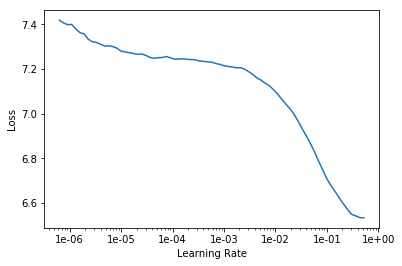

In [11]:
learn.recorder.plot(skip_end=15)

In [24]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.899094,3.745179,0.365747


In [25]:
learn.save('fit_head')

In [10]:
learn.load('fit_head');

This language model attains very high accuracy. It correctly predicts the next word in a sequence 41% of the time. I imagine this is likely due to the structure of the dataset. Every sentence is a question. I imagine the model quickly learns that every sequence starts with a capital word and ends with a question mark.

In [11]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,3.560944,3.503275,0.390168
2,3.467552,3.418043,0.400555
3,3.414453,3.373503,0.406159
4,3.355242,3.336187,0.410356
5,3.314795,3.311865,0.413112
6,3.264708,3.293005,0.415067
7,3.217207,3.277193,0.416794
8,3.174417,3.268920,0.417875
9,3.145795,3.265650,0.418397
10,3.122617,3.266834,0.418241


In [12]:
learn.save('fine_tuned')

In [ ]:
learn.load('fine_tuned');

This is what the model produces when you allow it to predict a stream of text. The model has clearly picked up on the question format of the dataset. It's also interesting to see questions that are meaningless but strangely coherent.

"How will the universe change ifwe had a day of mass production of light?"

"What challenges did George Plate face during his life?"

In [13]:
learn.predict('How do I ', 100, temperature=1.1, min_p=0.001)

'How do I  calculate the output voltage in the node circuit ? xxbos xxmaj is it true that all xxmaj indians say something to xxmaj indians to become non xxmaj indians ? xxbos xxmaj why is xxmaj president xxmaj trump being on the silent agenda ? xxbos xxmaj how will this universe change if we had a day of mass production of light ? xxbos xxmaj what was the best way you been a kid , that just gave you good grades and got really good marks ( xxmaj no coaching ) by listening / listening ? xxbos xxmaj was there any role'

In [14]:
learn.predict('What are the ', 200, temperature=1.1, min_p=0.001)

"What are the  things to look for . in xxmaj gurgaon ? xxbos xxmaj in which xxmaj android phone is xxup app bought ? xxbos xxmaj what are the important chapters for xxup icse ( 2018 ) ? xxbos xxmaj what challenges did xxmaj george xxmaj place face during his life ? xxbos xxmaj what could be the most important achievement for a xxup ceo of an ios app development company ? xxbos xxmaj how should i prepare for xxup rbi assistant for 11th attempt xxup iit preparation , it 's good time in xxmaj maths , xxmaj geography , any subject ( xxup us ) ? xxbos xxmaj is the xxup usa ( xxup us - xxmaj russia ) good to move to ? xxbos xxmaj do i need to purchase insurance on my xxmaj paytm account that has been around by same agent at different times ? xxbos xxmaj how do you use ' n ' in a sentence ? xxbos xxmaj why is my voice so poor ? xxbos xxmaj in an entire paragraph , what is the most interesting and stupid answer to your face ? xxbos xxmaj which branch should i join in xxup vit if i have"

In [15]:
learn.save_encoder('fine_tuned_enc')

# Classifier

Now we use the fine tuned language model as the base of a classifier. This time instead of treating the data as a single long string, we will use individual questions associated with their label.

In [16]:
df = pd.read_csv(path/'train.csv')

In [17]:
df.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [18]:
data_clas = TextDataBunch.from_csv(path, 'train.csv', valid_pct=0.1, 
                                  vocab=data_lm.vocab, text_cols='question_text', 
                                  label_cols='target')

In [19]:
data_clas.show_batch()

text,target
xxbos xxfld 1 xxmaj what is [ math ] \ frac { \ xxunk } } \ tan ( \ tan ( { \ boxed { \ xxunk } \ sum _ { \ xxunk { \ infty } \ xxunk } \ sum _ { \ xxunk { \ infty } \ xxunk { \ xxunk } } _ { \ xxunk 's xxmaj law of xxmaj theoretical xxmaj,1
"xxbos xxfld 1 xxmaj what is the procedure , if i am flying to xxmaj morocco from xxmaj spain ? xxmaj my husband and i are planning a trip to both xxmaj spain and xxmaj morocco from xxmaj india . xxmaj we first plan to fly to xxmaj spain ( i know we need xxmaj schengen for that ) . xxmaj what about xxmaj morocco ?",0
"xxbos xxfld 1 xxmaj why is my wife ’s xxmaj yahoo email account is tied to a non - portable xxup ip address , while the other 20 xxmaj yahoo e - mail addresses in my friend contacts list all are tied to portable xxup ip ’s ? xxmaj what ’s the realistic meaning of this and is it a fluke or intentional ?",0
"xxbos xxfld 1 xxmaj why is xxmaj kant 's "" transcendental xxmaj deduction of the xxmaj categories of xxmaj pure xxmaj understanding "" quite so murky in both of its versions ? xxmaj what exactly is the transcendental xxmaj deduction trying to do , and does it succeed ? xxmaj how , if at all , could xxmaj kant have clarified it ?",0
"xxbos xxfld 1 xxmaj why are so many people asking stupid questions about xxmaj méxico and xxmaj mexicans here on xxmaj quora ( i.e. , why do xxmaj mexicans speak only xxmaj spanish , is xxmaj mexico safe , why wo n't xxmaj mexicans pay for the wall , how does it feel to be xxmaj mexican , and so on ) ?",1


In [20]:
data_clas.save('tmp_clas')

In [21]:
x,y = next(iter(data_clas.valid_dl))

In [4]:
bs = 300
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=bs)
data_clas.show_batch()

text,target
xxbos xxfld 1 xxmaj what is [ math ] \ frac { \ xxunk } } \ tan ( \ tan ( { \ boxed { \ xxunk } \ sum _ { \ xxunk { \ infty } \ xxunk } \ sum _ { \ xxunk { \ infty } \ xxunk { \ xxunk } } _ { \ xxunk 's xxmaj law of xxmaj theoretical xxmaj,1
"xxbos xxfld 1 xxmaj how would you arrange the following in terms of acting skills , xxmaj alia xxmaj bhatt , xxmaj anushka xxmaj sharma , xxmaj deepika p , xxunk xxmaj kangana xxmaj ranaut , xxmaj jacqueline xxmaj xxunk , xxmaj xxunk xxmaj sinha , xxmaj parineeti xxmaj chopra , xxmaj shraddha xxmaj kapoor , xxmaj sonam xxmaj kapoor , xxmaj katrina xxmaj kaif and xxmaj priyanka xxmaj chopra",0
xxbos xxfld 1 i 'm currently residing in xxup usa with a non - expired xxup h-1b visa but i stopped working 24 days ago ( 36 days grace period remaining ) . xxmaj can i drive to xxmaj canada and re - enter xxup usa under xxup xxunk to extend my allowable stay by 90 days ? ( i 'm xxmaj south xxmaj korean xxmaj citizen ),0
"xxbos xxfld 1 xxmaj is a 3.15 inch penis normal for a 14 year old boy ? xxmaj all my friends say they ’re at 5 inches or bigger and i do n’t know if they ’re just fucking around or being serious . xxmaj am i average ? xxmaj if not , does this mean i ’m going to have a small penis in the future ?",1
"xxbos xxfld 1 xxmaj how long can aquatic turtles survive without xxup uvb or xxup uva ? xxmaj my new xxup uv lamp wo n't come until xxmaj april 6th . xxmaj right now it 's xxmaj march 17 . i heard a lot of people say that they had taken care of turtles for years without xxup uvb , and that it 's not really important .",0


In [6]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

This is the classifier model. You will notice that everything is the same as the language model except the final section of linear layers. We directly load in the weights from the language model into the embedding/LSTM section of this model.

The linear head on the classifier is called a `PoolingLinearClassifier`. This is a bit more sophistocated than a typical linear layer. The final output from the final LSTM is a 1x400 vector. However the output also contains all the hidden states from the various words that passed through the model before the final word. fastai's `PoolingLinearClassifier` takes these previous hidden states and performs max pooling and average pooling over them to produce two additional 1x400 vectors. These three output vectors are then concatenated together to form a single 1x1200 vector. This is what is actually sent to the final linear layers.

In [7]:
learn.model

SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(60003, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60003, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.1)
      (6): Linear(in_features=50, out_features=2, bias=T

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


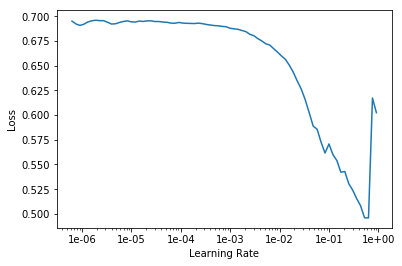

In [8]:
learn.lr_find()
learn.recorder.plot()

Here we train the classifier with discriminative learning rates and gradual unfreezing. For this first cycle, we train only the linear head.

In [8]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.146043,0.119611,0.951023


In [9]:
learn.save('first')

Now we unfreeze the final LSTM layer and continue training. We train the LSTM layer at a lower learning rate than the linear head.

In [10]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.103932,0.106449,0.957370


In [11]:
learn.save('second')

Now we unfreeze the middle LSTM and continue

In [12]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.103889,0.099211,0.960081


In [13]:
learn.save('third')

In [9]:
learn.load('third');

Finally we unfreeze the first LSTM layer and the embedding and continue training

In [10]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.094923,0.096787,0.961191
2,0.098485,0.095767,0.961987


In [11]:
learn.save('fourth')

The model is able to achieve high accuracy. This is deceiving however, as the dataset distribution of questions is heavily skewed. That said, the model does a good job of predicting the sincerity of some easy examples.

In [12]:
learn.predict("How do I change my tire?")

(Category 0, tensor(0), tensor([0.9986, 0.0014]))

In [17]:
learn.predict("Why are you so stupid?")

(Category 1, tensor(1), tensor([0.0416, 0.9584]))